#jhbl

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
!wget http://www.manythings.org/anki/ita-eng.zip
!unzip ita-eng.zip

--2020-11-24 13:48:03--  http://www.manythings.org/anki/ita-eng.zip
Resolving www.manythings.org (www.manythings.org)... 104.24.109.196, 104.24.108.196, 172.67.173.198, ...
Connecting to www.manythings.org (www.manythings.org)|104.24.109.196|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7521114 (7.2M) [application/zip]
Saving to: ‘ita-eng.zip’

ita-eng.zip         100%[===================>]   7.17M  6.13MB/s    in 1.2s    

2020-11-24 13:48:05 (6.13 MB/s) - ‘ita-eng.zip’ saved [7521114/7521114]

Archive:  ita-eng.zip
  inflating: ita.txt                 
  inflating: _about.txt              


In [3]:
!wget https://www.dropbox.com/s/ddkmtqz01jc024u/glove.6B.100d.txt

--2020-11-24 13:48:11--  https://www.dropbox.com/s/ddkmtqz01jc024u/glove.6B.100d.txt
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.1, 2620:100:6021:1::a27d:4101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/ddkmtqz01jc024u/glove.6B.100d.txt [following]
--2020-11-24 13:48:11--  https://www.dropbox.com/s/raw/ddkmtqz01jc024u/glove.6B.100d.txt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc6f4d48a686f2674df8cca60079.dl.dropboxusercontent.com/cd/0/inline/BDwzhOIkRSo56AaUOqQnSiTd4-GAQQpwTwjLmzWq5gkh_sA_6ngwNrwdSPcwz-hGwbJGmCrvh15soikvaMv5zoeJ7V4kbMn-_4elHpsYKHNFklkvmgeBZZ7bB_oSrtY0eLU/file# [following]
--2020-11-24 13:48:12--  https://uc6f4d48a686f2674df8cca60079.dl.dropboxusercontent.com/cd/0/inline/BDwzhOIkRSo56AaUOqQnSiTd4-GAQQpwTwjLmzWq5gkh_sA_6ngwNrwdSPcwz-hGwbJGmCrvh15soikvaMv5zoeJ7V4kbMn-

### <font color='blue'>**Loading data**</font>

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
# import seaborn as sns
import pandas as pd
import re
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense,Concatenate,TimeDistributed,Masking,GRU
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import numpy as np

In [6]:
with open('ita.txt', 'r', encoding="utf8") as f:
    eng=[]
    ita=[]
    for i in f.readlines():
        eng.append(i.split("\t")[0])
        ita.append(i.split("\t")[1])
data = pd.DataFrame(data=list(zip(eng, ita)), columns=['english','italian'])
print(data.shape)
data.head()

(343813, 2)


,english,italian
0,Hi.,Ciao!
1,Run!,Corri!
2,Run!,Corra!
3,Run!,Correte!
4,Who?,Chi?


In [7]:
def decontractions(phrase):
    # ref: https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python/47091490#47091490"""
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"won\’t", "will not", phrase)
    phrase = re.sub(r"can\’t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)

    phrase = re.sub(r"n\’t", " not", phrase)
    phrase = re.sub(r"\’re", " are", phrase)
    phrase = re.sub(r"\’s", " is", phrase)
    phrase = re.sub(r"\’d", " would", phrase)
    phrase = re.sub(r"\’ll", " will", phrase)
    phrase = re.sub(r"\’t", " not", phrase)
    phrase = re.sub(r"\’ve", " have", phrase)
    phrase = re.sub(r"\’m", " am", phrase)

    return phrase

def preprocess(text):

    text = text.lower()
    text = decontractions(text)
    text = re.sub('[^A-Za-z0-9 ]+', '', text)
    return text

def preprocess_ita(text):

    
    text = text.lower()
    text = decontractions(text)
    text = re.sub('[$)\?"’.°!;\'€%:,(/]', '', text)
    text = re.sub('\u200b', ' ', text)
    text = re.sub('\xa0', ' ', text)
    text = re.sub('-', ' ', text)
    return text


data['english'] = data['english'].apply(preprocess)
data['italian'] = data['italian'].apply(preprocess_ita)
data.head()

,english,italian
0,hi,ciao
1,run,corri
2,run,corra
3,run,correte
4,who,chi


In [8]:
ita_lengths = data['italian'].str.split().apply(len)
eng_lengths = data['english'].str.split().apply(len)

In [9]:
for i in range(0,101,10):
    print(i,np.percentile(ita_lengths, i))
for i in range(90,101):
    print(i,np.percentile(ita_lengths, i))
for i in [99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100]:
    print(i,np.percentile(ita_lengths, i))

0 1.0
10 3.0
20 4.0
30 4.0
40 5.0
50 5.0
60 6.0
70 6.0
80 7.0
90 8.0
100 92.0
90 8.0
91 8.0
92 8.0
93 9.0
94 9.0
95 9.0
96 10.0
97 10.0
98 11.0
99 12.0
100 92.0
99.1 12.0
99.2 12.0
99.3 13.0
99.4 13.0
99.5 13.0
99.6 14.0
99.7 15.0
99.8 16.0
99.9 20.0
100 92.0


In [10]:
for i in range(0,101,10):
    print(i,np.percentile(eng_lengths, i))
for i in range(90,101):
    print(i,np.percentile(eng_lengths, i))
for i in [99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100]:
    print(i,np.percentile(eng_lengths, i))

0 1.0
10 4.0
20 4.0
30 5.0
40 5.0
50 6.0
60 6.0
70 7.0
80 7.0
90 8.0
100 101.0
90 8.0
91 9.0
92 9.0
93 9.0
94 9.0
95 9.0
96 10.0
97 10.0
98 11.0
99 12.0
100 101.0
99.1 12.0
99.2 13.0
99.3 13.0
99.4 13.0
99.5 14.0
99.6 14.0
99.7 15.0
99.8 16.0
99.9 21.18800000002375
100 101.0


> <font color="blue"><b>If you observe the values, 99.9% of the data points are having length &lt; 20, so select the sentences that have words &lt; 20 </b> </font>
<br>
<br>
> <font color="green"><b>Inorder to do the teacher forcing while training of seq-seq models, lets create two new columns, one with  &lt;start&gt; token at begining of the sentence and other column with &lt;end&gt; token at the end of the sequence</b></font>

In [11]:
data['italian_len'] = data['italian'].str.split().apply(len)
data = data[data['italian_len'] < 20]

data['english_len'] = data['english'].str.split().apply(len)
data = data[data['english_len'] < 20]

data['english_inp'] = '<start> ' + data['english'].astype(str)
data['english_out'] = data['english'].astype(str) + ' <end>'

data = data.drop(['english','italian_len','english_len'], axis=1)
# only for the first sentance add a toke <end> so that we will have <end> in tokenizer
data.head()

,italian,english_inp,english_out
0,ciao,<start> hi,hi <end>
1,corri,<start> run,run <end>
2,corra,<start> run,run <end>
3,correte,<start> run,run <end>
4,chi,<start> who,who <end>


In [12]:
data.sample(10)

,italian,english_inp,english_out
147889,io devo cambiarmi i vestiti,<start> i have to change clothes,i have to change clothes <end>
316873,tom è stato assegnato ad una famiglia adottiva,<start> tom has been placed with a foster family,tom has been placed with a foster family <end>
206185,lo potrebbe ripetere per piacere,<start> could you please repeat that,could you please repeat that <end>
68499,avete avuto una lunga giornata,<start> you had a long day,you had a long day <end>
134501,io sono la nuova segretaria di tom,<start> i am tom is new secretary,i am tom is new secretary <end>
274602,tom non sa molto di musica,<start> tom does not know much about music,tom does not know much about music <end>
311397,annoterò il tuo nome e il tuo indirizzo,<start> i will write down your name and address,i will write down your name and address <end>
82748,a voi non è mai piaciuto tom,<start> you never liked tom,you never liked tom <end>
32224,voi dormivate,<start> you were asleep,you were asleep <end>
271256,io non lho ancora visto a boston,<start> i have not seen that in boston yet,i have not seen that in boston yet <end>


In [13]:
data.shape

(343388, 3)

### Getting train and test 

In [14]:
from sklearn.model_selection import train_test_split
train, validation = train_test_split(data, test_size=0.2)

In [15]:
print(train.shape, validation.shape)
# for one sentence we will be adding <end> token so that the tokanizer learns the word <end>
# with this we can use only one tokenizer for both encoder output and decoder output
train.iloc[0]['english_inp']= str(train.iloc[0]['english_inp'])+' <end>'
train.iloc[0]['english_out']= str(train.iloc[0]['english_out'])+' <end>'

(274710, 3) (68678, 3)


In [16]:
train.head()

,italian,english_inp,english_out
73924,saltai la colazione,<start> i skipped breakfast <end>,i skipped breakfast <end> <end>
219791,lei deve ancora pagarla,<start> you still have to pay for it,you still have to pay for it <end>
202778,noi non abbiamo fatto alcuna domanda,<start> we did not ask any questions,we did not ask any questions <end>
156247,accettiamo la vostra sfida,<start> we accept your challenge,we accept your challenge <end>
26665,ho contato su di lui,<start> i relied on him,i relied on him <end>


In [17]:
validation.head()

,italian,english_inp,english_out
86361,lho già chiamato,<start> i already called him,i already called him <end>
322508,speriamo che tutto vada meglio domani,<start> let is hope everything gets better tom...,let is hope everything gets better tomorrow <end>
52449,tom è semplice,<start> tom is unaffected,tom is unaffected <end>
99985,è già suonata la campanella,<start> has the bell rung yet,has the bell rung yet <end>
57206,non mi dia quella,<start> do not give me that,do not give me that <end>


In [18]:

import seaborn as sns

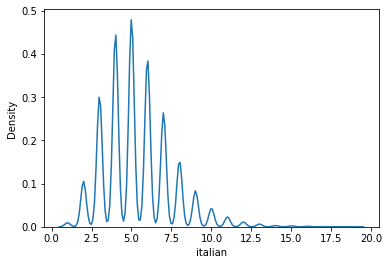

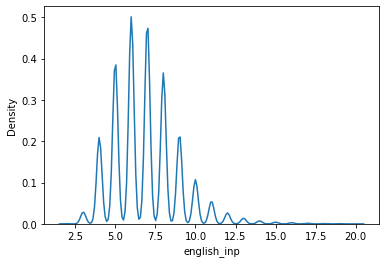

In [19]:
ita_lengths = train['italian'].str.split().apply(len)
eng_lengths = train['english_inp'].str.split().apply(len)
import seaborn as sns
sns.kdeplot(ita_lengths)
plt.show()
sns.kdeplot(eng_lengths)
plt.show()

### Creating Tokenizer on the train data and learning vocabulary

> Note that we are fitting the tokenizer only on train data and check the filters for english, we need to remove symbols &lt; and &gt;

In [20]:
tknizer_ita = Tokenizer()
tknizer_ita.fit_on_texts(train['italian'].values)
tknizer_eng = Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
tknizer_eng.fit_on_texts(train['english_inp'].values)

In [21]:
len(tknizer_eng.word_index.keys())

12838

In [22]:
vocab_size_eng=len(tknizer_eng.word_index.keys())
print(vocab_size_eng)
vocab_size_ita=len(tknizer_ita.word_index.keys())
print(vocab_size_ita)

12838
26240


In [23]:
tknizer_eng.word_index['<start>'], tknizer_eng.word_index['<end>']

(1, 10137)

In [24]:
data.shape

(343388, 3)

In [25]:
def grader_1(data):
    shape_value = data.shape ==(340044, 3)
    tknizer = Tokenizer(char_level=True)
    tknizer.fit_on_texts(data['italian'].values)
    ita_chars = tknizer.word_index.keys()
    diff_chars_ita = set(ita_chars)-set([' ', 't', 'a', 'o', 'r', 'e', 's', 'i', 'n', 'l', 'c', 'm', 'u', 'd', 'p', 'v', 'h', 'g', 'b', 'f', 'è', 'q', 'z', 'ò', 'à', 'y', 'é', 'ì', 'ù', 'k', 'w', '0', 'j', '1', '3', '2', 'x', '9', '5', '8', '4', '6', '7', 'á', 'ñ', 'ê', 'ü', 'ō', 'î', 'ö', 'ú', 'º'])
    tknizer = Tokenizer(char_level=True)
    tknizer.fit_on_texts(data['english_inp'].values)
    eng_chars = tknizer.word_index.keys()
    diff_chars_eng = set(eng_chars)-set(['<','>',' ', 'e', 'o', 't', 'i', 'a', 'n', 's', 'h', 'r', 'l', 'd', 'm', 'y', 'u', 'w', 'g', 'c', 'p', 'f', 'b', 'k', 'v', 'j', 'x', 'z', 'q', '0', '1', '3', '2', '9', '5', '8', '6', '4', '7'])
    unique_char_value = (len(diff_chars_eng)==0) and (len(diff_chars_ita)==0)
    return unique_char_value and shape_value

grader_1(data)

False

### Creating embeddings for english sentences

In [26]:
embeddings_index = dict()
f = open('glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

embedding_matrix = np.zeros((vocab_size_eng+1, 100))
for word, i in tknizer_eng.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [27]:
class Dataset:
    def __init__(self, data, tknizer_ita, tknizer_eng, max_len):
        self.encoder_inps = data['italian'].values
        self.decoder_inps = data['english_inp'].values
        self.decoder_outs = data['english_out'].values
        self.tknizer_eng = tknizer_eng
        self.tknizer_ita = tknizer_ita
        self.max_len = max_len

    def __getitem__(self, i):
        self.encoder_seq = self.tknizer_ita.texts_to_sequences([self.encoder_inps[i]]) # need to pass list of values
        self.decoder_inp_seq = self.tknizer_eng.texts_to_sequences([self.decoder_inps[i]])
        self.decoder_out_seq = self.tknizer_eng.texts_to_sequences([self.decoder_outs[i]])

        self.encoder_seq = pad_sequences(self.encoder_seq, maxlen=self.max_len, dtype='int32', padding='post')
        self.decoder_inp_seq = pad_sequences(self.decoder_inp_seq, maxlen=self.max_len, dtype='int32', padding='post')
        self.decoder_out_seq = pad_sequences(self.decoder_out_seq, maxlen=self.max_len, dtype='int32', padding='post')
        return self.encoder_seq, self.decoder_inp_seq, self.decoder_out_seq

    def __len__(self): # your model.fit_gen requires this function
        return len(self.encoder_inps)

    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1):
        self.dataset = dataset
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.dataset.encoder_inps))


    def __getitem__(self, i):
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])

        batch = [np.squeeze(np.stack(samples, axis=1), axis=0) for samples in zip(*data)]
        # we are creating data like ([italian, english_inp], english_out) these are already converted into seq
        return tuple([[batch[0],batch[1]],batch[2]])

    def __len__(self):  # your model.fit_gen requires this function
        return len(self.indexes) // self.batch_size

    def on_epoch_end(self):
        self.indexes = np.random.permutation(self.indexes)

In [28]:
init=tf.keras.initializers.HeNormal(
    seed=None
)

In [29]:
class Encoder(tf.keras.Model):
    def __init__(self,inp_vocab_size,embedding_size,lstm_size,input_length):
        super().__init__()
        self.inp_vocab_size=inp_vocab_size
        self.embedding_size=embedding_size
        self.lstm_size=lstm_size
        self.input_length=input_length
        self.lstm_output = 0
        self.lstm_state_h=0
        self.lstm_state_c=0
    def build(self, input_shape):
        self.embedding = Embedding(input_dim=self.inp_vocab_size, output_dim=self.embedding_size, input_length=self.input_length, name="embedding_layer_encoder",embeddings_initializer=init)
        self.masking=Masking(mask_value=0)
        self.lstm = LSTM(self.lstm_size, return_state=True, name="Encoder_LSTM",kernel_initializer=init,dropout=0.2)
    def call(self,input_sequence,training=True):
        input_embedd = self.embedding(input_sequence)
        input_embedd=self.masking(input_embedd)
        self.lstm_output, self.lstm_state_h,self.lstm_state_c = self.lstm(input_embedd)
        return self.lstm_output, self.lstm_state_h,self.lstm_state_c
        
    def get_states(self):
        return self.lstm_state_h,self.lstm_state_c

In [30]:
class Decoder(tf.keras.Model):
    def __init__(self,out_vocab_size,embedding_size,lstm_size,input_length):
        super().__init__()
        self.out_vocab_size=out_vocab_size
        self.embedding_size=embedding_size
        self.lstm_size=lstm_size
        self.input_length=input_length
    def build(self, input_shape):
        self.embedding = Embedding(input_dim=self.out_vocab_size, output_dim=self.embedding_size, input_length=None,
                           name="embedding_layer_decoder",weights=[embedding_matrix], trainable=False)
        self.masking=Masking(mask_value=0)
        self.lstm = LSTM(self.lstm_size, return_state=True, return_sequences=True, name="Decoder_LSTM",kernel_initializer=init,dropout=0.2)
    def call(self,target_sentances,state_h,state_c):
        #print("DECODER ==> IN PUT SQUENCES SHAPE :",target_sentances.shape)
        target_embedd           = self.embedding(target_sentances)
        target_embedd=self.masking(target_embedd)
        #print("WE ARE INITIALIZING DECODER WITH ENCODER STATES :",state_h.shape, state_c.shape)
        lstm_output,dec_h,dec_c       = self.lstm(target_embedd, initial_state=[state_h, state_c])
        return lstm_output,dec_h,dec_c

In [31]:
class Encoder_decoder(tf.keras.Model):
    def __init__(self,encoder_input_length,decoder_input_length,output_vocabsize):
        super().__init__()
        self.encoder = Encoder(inp_vocab_size=vocab_size_ita+1,embedding_size=100,input_length=encoder_input_length, lstm_size=512)
        self.decoder = Decoder(out_vocab_size=vocab_size_eng+1, embedding_size=100, input_length=decoder_input_length, lstm_size=512)
        self.dense   = TimeDistributed(Dense(units=output_vocabsize+1,activation="softmax",kernel_initializer=init)    )
    def call(self, data):
        input,output = data[0], data[1]
        #print("="*20, "ENCODER", "="*20)
        encoder_output, encoder_h, encoder_c = self.encoder(input)
        decoder_output                       = self.decoder(output, encoder_h, encoder_c)[0]
        output                               = self.dense(decoder_output)
        return output    

In [32]:
embedding_matrix.shape

(12839, 100)

In [33]:
train_dataset = Dataset(data, tknizer_ita, tknizer_eng, 20)

test_dataset  = Dataset(validation, tknizer_ita, tknizer_eng, 20)

train_dataloader = Dataloder(train_dataset, batch_size=1024)
test_dataloader = Dataloder(test_dataset, batch_size=1024)


print(train_dataloader[0][0][0].shape, train_dataloader[0][0][1].shape, train_dataloader[0][1].shape)

(1024, 20) (1024, 20) (1024, 20)


In [34]:
vocab_size_eng

12838

### Callbacks


In [35]:
#earlystopping
import numpy as np


class EarlyStoppingAtMinLoss(tf.keras.callbacks.Callback):
    """Stop training when the loss is at its min, i.e. the loss stops decreasing.

  Arguments:
      patience: Number of epochs to wait after min has been hit. After this
      number of no improvement, training stops.
  """

    def __init__(self, patience=3):
        super(EarlyStoppingAtMinLoss, self).__init__()
        self.patience = patience
        # best_weights to store the weights at which the minimum loss occurs.
        self.best_weights = None

    def on_train_begin(self, logs=None):
        # The number of epoch it has waited when loss is no longer minimum.
        self.wait = 0
        # The epoch the training stops at.
        self.stopped_epoch = 0
        # Initialize the best as infinity.
        #self.best = np.Inf

    def on_epoch_end(self, epoch, logs=None):
        current_loss = logs.get("loss")
        current_valloss = logs.get("val_loss")
        if np.less(current_valloss,current_loss):
            #self.best = current
            self.wait = 0
            # Record the best weights if current results is better (less).
            self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                print("Restoring model weights from the end of the best epoch.")
                self.model.set_weights(self.best_weights)

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print("Epoch %05d: early stopping" % (self.stopped_epoch + 1))




In [41]:
model  = Encoder_decoder(encoder_input_length=20,decoder_input_length=None,output_vocabsize=vocab_size_eng)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy')
train_steps=train.shape[0]//1024
valid_steps=validation.shape[0]//1024
history=model.fit_generator(train_dataloader, steps_per_epoch=train_steps, epochs=50, validation_data=train_dataloader, validation_steps=valid_steps,verbose=1)
model.summary()

Epoch 1/50
268/268 [==============================] - 107s 398ms/step - loss: 1.4830 - val_loss: 0.7293
Epoch 2/50
268/268 [==============================] - 104s 389ms/step - loss: 1.2404 - val_loss: 0.6568
Epoch 3/50
268/268 [==============================] - 104s 389ms/step - loss: 1.1020 - val_loss: 0.5792
Epoch 4/50
268/268 [==============================] - 104s 389ms/step - loss: 0.9963 - val_loss: 0.5242
Epoch 5/50
268/268 [==============================] - 104s 390ms/step - loss: 0.8921 - val_loss: 0.4531
Epoch 6/50
268/268 [==============================] - 104s 389ms/step - loss: 0.7774 - val_loss: 0.3742
Epoch 7/50
268/268 [==============================] - 105s 391ms/step - loss: 0.7015 - val_loss: 0.3194
Epoch 8/50
268/268 [==============================] - 104s 389ms/step - loss: 0.6241 - val_loss: 0.2619
Epoch 9/50
268/268 [==============================] - 104s 389ms/step - loss: 0.5420 - val_loss: 0.2144
Epoch 10/50
268/268 [==============================] - 104s 390m

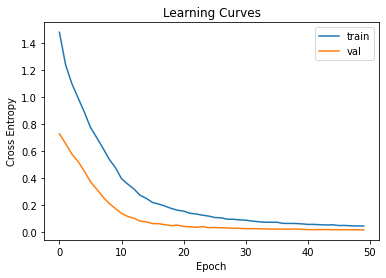

In [42]:
import matplotlib.pyplot as plt
plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()


In [ ]:
"""
import matplotlib.pyplot as plt
plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()
"""

"\nimport matplotlib.pyplot as plt\nplt.title('Learning Curves')\nplt.xlabel('Epoch')\nplt.ylabel('Cross Entropy')\nplt.plot(history.history['loss'], label='train')\nplt.plot(history.history['val_loss'], label='val')\nplt.legend()\nplt.show()\n"

In [43]:

def predic_fun(input_sentence):
    input_pred=[tknizer_ita.word_index[i] for i in input_sentence.split()] 
    print("input tokens",input_pred)
    a,b,c=model.layers[0](np.expand_dims(input_pred, 0))
    state_values=[b,c]
    start="<start>"
    pred=[]
    for i in range(0,20):
        start=tknizer_eng.word_index[start] 
        cur_vec = np.array(start).reshape(1,1)
        cur_emb=model.layers[1].embedding(cur_vec)
        infe_output, state_h, state_c = model.layers[1].lstm(cur_emb, initial_state=state_values)
        state_values=[state_h, state_c]
        infe_output=model.layers[2](infe_output)
        ind=np.argmax(infe_output)
        start=tknizer_eng.index_word[ind]
        print("new eng word",start)
        pred.append(tknizer_eng.index_word[ind])
        if start=="<end>":
            break
    return pred

In [44]:
model.layers

In [47]:
predic_fun("correte")

input tokens [6437]
new eng word or
new eng word not
new eng word take
new eng word <end>


['or', 'not', 'take', '<end>']

In [ ]:
data.head()

,italian,english_inp,english_out
0,ciao,<start> hi,hi <end>
1,corri,<start> run,run <end>
2,corra,<start> run,run <end>
3,correte,<start> run,run <end>
4,chi,<start> who,who <end>


In [ ]:
start="<start>"
start=tknizer_eng.word_index[start] 

print(cur_vec)
cur_emb=model.layers[1].embedding(cur_vec)
infe_output, state_h, state_c = model.layers[1].lstm(cur_emb, initial_state=state_values)

[[1]]


In [ ]:
(model.layers[2](infe_output))

<tf.Tensor: shape=(1, 1, 12824), dtype=float32, numpy=
array([[[4.4696963e-06, 4.8093671e-06, 3.4546074e-02, ...,
         5.9254130e-06, 5.9093695e-06, 6.6285579e-06]]], dtype=float32)>